In [1]:
# pip install scrapy
# pip install --upgrade zope2

from collections import Counter
import foursquare
from ipywidgets import widgets
from IPython.display import display
import json
import matplotlib.pyplot as plt
import numpy as np
import operator
from operator import itemgetter
import pandas as pd
import pickle
import random
import requests
from scrapy import Selector
from scrapy.http import HtmlResponse
import seaborn as sns
from sqlalchemy import create_engine
import sqlite3
import textacy
import textacy.data
import time
import unicodedata

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [10]:
updated_food = pd.read_pickle('../../../../Accounts/Electo:Computad/\
MacBook Pro/Software/Github/Old_repos/DSI-SF-4-anotherguitar/projects/Capstone Stuff/updated_food.pkl')

In [11]:
# Make a function that will put a 1 in the row if that group is represented, and 0 if not:
def check_group(ref_group, food_groups):
    
    if food_groups == None:
        return 0
    elif len(food_groups.split(',')) == 1:
        if ref_group.replace(',','') in food_groups:
            return 1
        else:
            return 0

    elif len(food_groups.split(',')) >= 1:
        for a_group in food_groups.split(','):
            if ref_group.replace(',','') in a_group:
                return 1
        return 0
    else:
        return 0

In [26]:
#This will put 1 in for vegan in the target column, and 0 in for the non-vegan items
updated_food.vegan_venue_check = updated_food.vegan_venue_check.map(lambda x: 1 if x == 'vegan' else 0)

In [15]:
fe_columns = [
        'Dairy and Egg Products', 'Spices and Herbs', 'Fats and Oils',
       'Poultry Products', 'Soups, Sauces, and Gravies',
       'Sausages and Luncheon Meats', 'Breakfast Cereals', 'Snacks',
       'Fruits and Fruit Juices', 'Pork Products',
       'Vegetables and Vegetable Products', 'Nut and Seed Products',
       'Beef Products', 'Beverages', 'Finfish and Shellfish Products',
       'Legumes and Legume Products', 'Lamb, Veal, and Game Products',
       'Baked Products', 'Sweets', 'Cereal Grains and Pasta',
       'Meals, Entrees, and Sidedishes'
]

In [17]:
# Able to update as needed for experimentation
tmp_banned_cat = [
    'American Indian/Alaska Native Foods',
    'Baby Foods',
#     'Baked Products',
#     'Beef Products',
#     'Beverages',
#     'Breakfast Cereals',
#     'Cereal Grains and Pasta',
#     'Dairy and Egg Products',
    'Fast Foods',
#     'Fats and Oils',
#     'Finfish and Shellfish Products',
#     'Fruits and Fruit Juices',
#     'Lamb, Veal, and Game Products',
#     'Legumes and Legume Products',
    'Meals, Entrees, and Sidedishes',
#     'Nut and Seed Products',
#     'Pork Products',
#     'Poultry Products',
    'Restaurant Foods',
#     'Sausages and Luncheon Meats',
#     'Snacks',
#     'Soups, Sauces, and Gravies',
#     'Spices and Herbs',
#     'Sweets',
#     'Vegetables and Vegetable Products'
    ]

__First, we can run this on the "item_fg" category__

In [83]:
modelled_food = updated_food.drop([
        'Dairy and Egg Products', 'Spices and Herbs', 'Fats and Oils',
       'Poultry Products', 'Soups, Sauces, and Gravies',
       'Sausages and Luncheon Meats', 'Breakfast Cereals', 'Snacks',
       'Fruits and Fruit Juices', 'Pork Products',
       'Vegetables and Vegetable Products', 'Nut and Seed Products',
       'Beef Products', 'Beverages', 'Finfish and Shellfish Products',
       'Legumes and Legume Products', 'Lamb, Veal, and Game Products',
       'Baked Products', 'Sweets', 'Cereal Grains and Pasta',
       'Meals, Entrees, and Sidedishes'
    ], axis=1)
modelled_food.columns

Index([u'venue_name', u'venue_desc_list', u'vegan_venue_check',
       u'venue_menu_url', u'venue_rated', u'meta_menu_n', u'depth_menus_n',
       u'menu_item_name', u'menu_item_price', u'menu_item_desc',
       u'count_desc_list', u'count_item_name', u'count_item_desc', u'item_fg',
       u'depth_menu_fg', u'item_fg_renewed', u'meta_menu_fg'],
      dtype='object')

In [84]:
for i in fe_columns:
#     print 'next loop'
    if i.replace(',','') not in tmp_banned_cat:
        current_ref_group = i.replace(',','')
        modelled_food[i] = modelled_food.item_fg.map(lambda x: check_group(current_ref_group, x))

now run the model over the dataframe only inclusive of the correct features

In [85]:
modelled_food.columns

Index([u'venue_name', u'venue_desc_list', u'vegan_venue_check',
       u'venue_menu_url', u'venue_rated', u'meta_menu_n', u'depth_menus_n',
       u'menu_item_name', u'menu_item_price', u'menu_item_desc',
       u'count_desc_list', u'count_item_name', u'count_item_desc', u'item_fg',
       u'depth_menu_fg', u'item_fg_renewed', u'meta_menu_fg',
       u'Dairy and Egg Products', u'Spices and Herbs', u'Fats and Oils',
       u'Poultry Products', u'Soups, Sauces, and Gravies',
       u'Sausages and Luncheon Meats', u'Breakfast Cereals', u'Snacks',
       u'Fruits and Fruit Juices', u'Pork Products',
       u'Vegetables and Vegetable Products', u'Nut and Seed Products',
       u'Beef Products', u'Beverages', u'Finfish and Shellfish Products',
       u'Legumes and Legume Products', u'Lamb, Veal, and Game Products',
       u'Baked Products', u'Sweets', u'Cereal Grains and Pasta',
       u'Meals, Entrees, and Sidedishes'],
      dtype='object')

In [86]:
# we're only looking at item_fg, so drop the others
modelled_food = modelled_food.drop([
        'venue_desc_list', 'venue_menu_url', 'depth_menu_fg', 'item_fg_renewed', 'meta_menu_fg'
    ], axis=1)

Now, we have the target at column index 1 (second column), and 25 primary targets. I've also included additional targets like 'venue_rated','meta_menu_n', 'depth_menus_n', 'menu_item_name', 'menu_item_price', 'menu_item_desc', 'count_desc_list', 'count_item_name','count_item_desc' in the hopes that they may improve (or at a minimum, not detract from) the quality of my models.

In [87]:
modelled_food = modelled_food.drop([
        'venue_name', 'meta_menu_n','depth_menus_n', 'menu_item_name', 'menu_item_desc',
        'venue_rated', 'menu_item_price','item_fg'
    ], axis=1)
modelled_food.columns

Index([u'vegan_venue_check', u'count_desc_list', u'count_item_name',
       u'count_item_desc', u'Dairy and Egg Products', u'Spices and Herbs',
       u'Fats and Oils', u'Poultry Products', u'Soups, Sauces, and Gravies',
       u'Sausages and Luncheon Meats', u'Breakfast Cereals', u'Snacks',
       u'Fruits and Fruit Juices', u'Pork Products',
       u'Vegetables and Vegetable Products', u'Nut and Seed Products',
       u'Beef Products', u'Beverages', u'Finfish and Shellfish Products',
       u'Legumes and Legume Products', u'Lamb, Veal, and Game Products',
       u'Baked Products', u'Sweets', u'Cereal Grains and Pasta',
       u'Meals, Entrees, and Sidedishes'],
      dtype='object')

Here, I'll first take a look at basic Linear and Logistic Regressions

In [138]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cross_validation import cross_val_score, train_test_split

In [89]:
Xr = modelled_food.iloc[:,1:]
yr = modelled_food.vegan_venue_check

Xc = modelled_food.iloc[:,1:]
yc = modelled_food.vegan_venue_check

In [91]:
# Linear
reg_scores = cross_val_score(LinearRegression(), Xr, yr, cv=4)
#Logistic
cls_scores = cross_val_score(LogisticRegression(), Xc, yc, cv=4)

print 'Linear Regression:', reg_scores, np.mean(reg_scores)
print 'Logistic Regression:', cls_scores, np.mean(cls_scores)

linreg = LinearRegression().fit(Xr, yr)
logreg = LogisticRegression().fit(Xc, yc)

Linear Regression: [-0.00433492  0.06956566  0.04609983  0.06665448] 0.044496260022
Logistic Regression: [ 0.97930085  0.97934435  0.97867709  0.9701035 ] 0.976856448558


Interestingly, the linear regression automatically returns better (over 2x) than baseline (which was at 2.07%), of about 4.4%. So technically, I already know that my food groups are performing okay relative to baseline. The logistic regression, though is clearly overfitting.

In [112]:
# Decision trees
from sklearn.tree import DecisionTreeRegressor

# REQUIREMENTS:
# pip install pydotplus
# brew install graphviz

# Use graphviz to make a chart of the regression tree decision points:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [118]:
dtr = DecisionTreeRegressor(max_depth=1)
dtr.fit(Xr, yr)

DecisionTreeRegressor(criterion='mse', max_depth=1, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [119]:
dtr_scores = cross_val_score(dtr, Xr, yr, cv=4)
print dtr_scores, np.mean(dtr_scores)
# Already I've been able to double my predictive score again, to something closer to 8 percent, but unfortunately,
# the model is attributing this primarily to the number of words in the venue description categories. (lol)

[ 0.01308817  0.12320949  0.07589955  0.11230577] 0.0811257446667


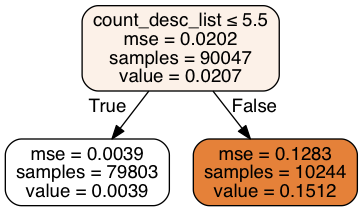

In [120]:
dot_data = StringIO()  

export_graphviz(dtr, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=Xr.columns)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

In [152]:
#Now the Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

In [142]:
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, train_size=0.7, stratify=yr)
print Xr_train.shape, yr_train.shape
print Xr_test.shape, yr_test.shape

(63032, 24) (63032,)
(27015, 24) (27015,)


In [145]:
dtc = DecisionTreeClassifier()
# dtc_params = {
#     'max_depth':[None,1,2,3,4],
#     'max_features':[None,'log2','sqrt','auto', 2,3,4,5],
#     'min_samples_split':[2,3,4,5,10,15,20,25,30,40,50]
# }

dtc_params = {
    'max_depth':[2,3,4],
    'max_features':[None],
    'min_samples_split':[2,3,4,5]
}

dtc_gs = GridSearchCV(dtc, dtc_params, n_jobs=-1, cv=5, verbose=1)

dtc_gs.fit(Xr_train, yr_train)
# dtc_scores = cross_val_score(dtc, Xc, yc, cv=4)
# print 'DT Classifier:', dtc_scores, np.mean(dtc_scores)

Fitting 5 folds for each of 440 candidates, totalling 2200 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 2200 out of 2200 | elapsed:  3.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [None, 'log2', 'sqrt', 'auto', 2, 3, 4, 5], 'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50], 'max_depth': [None, 1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [146]:
## Print best estimator, best parameters, and best score
dtc_best_estimator = dtc_gs.best_estimator_
print "best estimator\n", dtc_best_estimator

print "\n=========="
dct_best_param = dtc_gs.best_params_
print "best parameters\n",  dct_best_param 

print "\n=========="
print "best score\n", dtc_gs.best_score_

best estimator
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

best parameters
{'max_features': None, 'min_samples_split': 2, 'max_depth': 4}

best score
0.98002601853


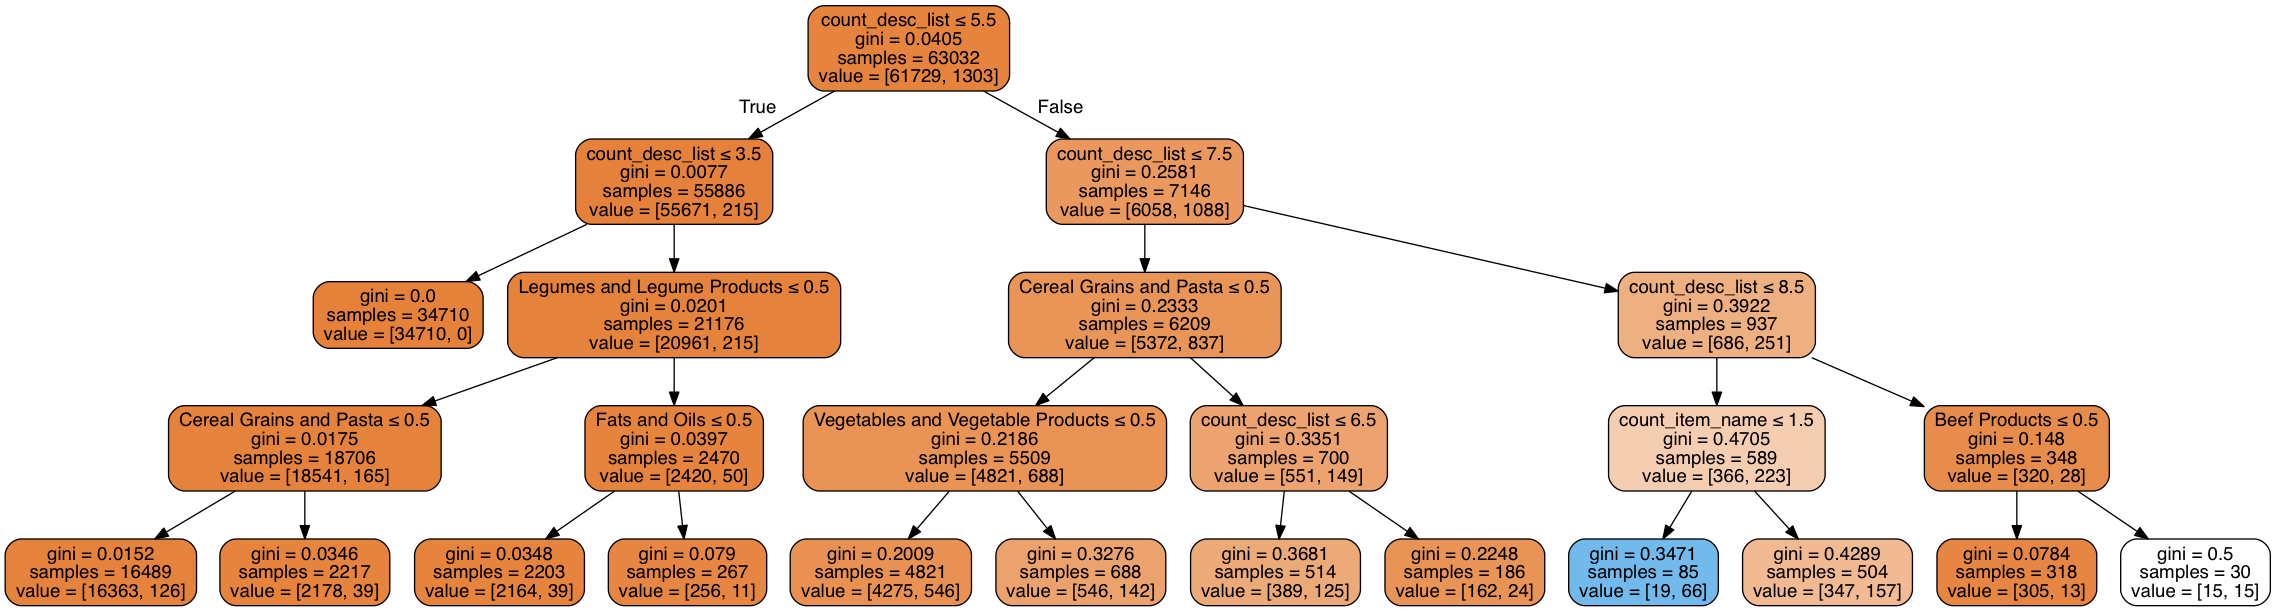

In [155]:
dot_data = StringIO()  

export_graphviz(dtc_best_estimator, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=Xr.columns)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

In [156]:
## Print Feature importances
feature_importance = pd.DataFrame({'feature':Xr.columns, 
                                   'importance':dtc_best_estimator.feature_importances_
                                  })

feature_importance.sort_values('importance', ascending=False, inplace=True)
feature_importance

,feature,importance
0,count_desc_list,0.845977
1,count_item_name,0.075350
15,Beef Products,0.027691
13,Vegetables and Vegetable Products,0.025029
22,Cereal Grains and Pasta,0.023959
18,Legumes and Legume Products,0.001364
5,Fats and Oils,0.000630
21,Sweets,0.000000
20,Baked Products,0.000000
19,"Lamb, Veal, and Game Products",0.000000


In [153]:
yr_pred= dtc_gs.predict(Xr_test)
cls_rep = classification_report(yr_test, yr_pred)
print cls_rep

             precision    recall  f1-score   support

          0       0.98      1.00      0.99     26457
          1       0.65      0.04      0.07       558

avg / total       0.97      0.98      0.97     27015



In [157]:
#Now the Random Forest
from sklearn.ensemble import RandomForestClassifier

In [158]:
rfc = RandomForestClassifier()

rf_params = {'max_features':[None,'log2','sqrt', 2,3,4,5],
             'max_depth':[1,2,3,None],
             'min_samples_leaf':np.linspace(1,101,20),
             'n_estimators':[100]
            }
rf_gs = GridSearchCV(rfc, rf_params, cv=5, verbose=1, n_jobs=-1)

# fit
rf_gs.fit(Xr_train, yr_train)

Fitting 5 folds for each of 560 candidates, totalling 2800 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   49.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.6min
Process PoolWorker-5:
  File "//anaconda/envs/dsi/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
Process PoolWorker-8:
Traceback (most recent call last):
  File "//anaconda/envs/dsi/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "//anaconda/envs/dsi/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self.run()
  File "//anaconda/envs/dsi/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "//anaconda/envs/dsi/lib/python2.7/multiprocessing/pool.py", line 113, in worker
    self._target(*self._args, **self._kwargs)
    result = (True, func(*args, **kwds))
KeyboardInterrupt
  File "//anaconda/envs/dsi/lib/python2.7/multiprocessing/pool.py

In [ ]:
## Print best estimator, best parameters, and best score
rfc_best = rf_gs.best_estimator_
print "best estimator\n", rfc_best
print "\n=========="
print "best parameters\n", rf_gs.best_params_
print "\n=========="
print "best score\n", rf_gs.best_score_

In [ ]:
## Print Feature importances
feature_importance = pd.DataFrame({ 'feature':Xr.columns, 
                                   'importance':rfc_best.feature_importances_
                                  })

feature_importance.sort_values('importance', ascending=False, inplace=True)
feature_importance

In [ ]:
yr_pred_rfc= rfc_best.predict(Xr_test)
cls_rep = classification_report(yr_test, yr_pred_rfc)
print cls_rep

In [ ]:
#be sure to show a confusion matrix for each result, and also an ROC curve
#then, when i find a model i like, i can also look into bagging and boosting

more ambiguous steps that i'll later have to push to the top, because all my features should leverage these things, like: (OR NOT?)

STOP WORDS

In [ ]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
sentence = "this is a foo bar sentence"
print [i for i in sentence.split() if i not in stop]

In [ ]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
print stemmer.stem('Swimmed')
print stemmer.stem('Swimming')

#maybe do POS? except more processing power required usually
# from nltk.tag import pos_tag
# from nltk.tokenize import WordPunctTokenizer
# tok = WordPunctTokenizer()
# pos_tag(tok.tokenize("today is a great day to learn nlp"))

hashing vectorizer might be helpful for going through all the descriptions for each food group (if i had more time)...

In [ ]:
# from sklearn.feature_extraction.text import HashingVectorizer
# hvec = HashingVectorizer()
# hvec.fit([spam])
# Slide Type
# #
# # .todense() is just returning it as an array.. toarray() would be a nicer name for this in sklearn
# #####
# df  = pd.DataFrame(hvec.transform([spam]).todense())
# df.transpose().sort_values(0, ascending=False).head(10).transpose()

__TRY THE COUNT VECTORIZER__

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer()
cvec.fit([spam])
CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)
df  = pd.DataFrame(cvec.transform([spam]).todense(),
             columns=cvec.get_feature_names())

df.transpose().sort_values(0, ascending=False).head(10).transpose()

try the TFIDF vectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer(stop_words='english')
tvec.fit([spam, ham])

__Then, we can run this on the item_fg_renewed category__

__We can also run this on the depth_menu_fg category__

__And finally on the meta_menu_fg category__

perform unique models on each of meta menu, item_fg (restricted to 3 fg's) and item_fg_renewed (newest preprocessing)